## Проблема подглядывания

Предположим, что мы отошли от классической схемы проведения АБ тестов и решили подводить итоги на уровне значимости 5% каждый день. Мы держим тест две недели. Если хотябы в один из дней p-value оказывается ниже $0.05$, мы останавливаем тест и делаем выводы, что гипотеза отвергается.

Так делать нельзя. Это называется проблемой подглядывания. В случае такой процедуры уровень значимости выходит из-под контроля. Убедимся в этом с помощью симуляций. 

- Запланируем АБ-тест для долей таким образом, чтобы ошибка 1 и 2 рода были равны 5%. В качестве MDE возьмите любое значение.
- Сгенерируем нужное количество наблюдений. Разбейте его на 14 частей (тест идет 2 недели)
- Проверяем гипотезу каждый день и останавливаемся, если она не отвергается
- Какими оказались ошибки 1 и 2 рода в реальности?

Симуляции проводим отдельно для верности нулевой гипотезы и отдельно для верности альтернативной гипотезы.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportions_ztest

plt.style.use('ggplot')
%matplotlib inline

**Симулируем, когда нулевая гипотеза верна, т.е. разница между контрольной и тестовой группой меньше MDE**

Если будем подглядывать, то остановимся на 2й день, т.к. p-value = 0.0488
Ошибка 1-го рода: 0.75


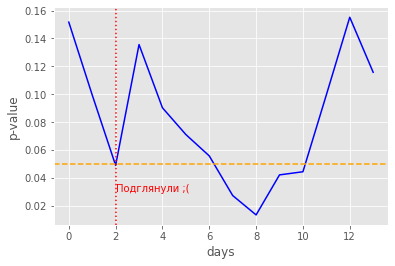

In [2]:
alpha, beta = 0.05, 0.05
p_c, p_t, MDE = 0.2, 0.195, 0.1
days = 14
pvalues = []

n_obs = zt_ind_solve_power(effect_size=MDE,
                                 nobs1=None,
                                 alpha=alpha,
                                 power=(1 - beta),
                                 ratio=1,
                                 alternative='larger')

n_obs = (n_obs + (days * 2 - n_obs % days))
pvalues = []
x_c = sts.bernoulli(p_c).rvs(int(n_obs // 2), random_state=98)
x_t = sts.bernoulli(p_t).rvs(int(n_obs // 2), random_state=92)
x_c = x_c.reshape(days, int(n_obs // 2 // days))
x_t = x_t.reshape(days, int(n_obs // 2 // days))


for day in range(days):
    x_c_day = x_c[:day+1]
    x_t_day = x_t[:day+1]

    pc_hat = x_c_day.sum()
    pt_hat = x_t_day.sum()

    pval = proportions_ztest([pt_hat, pc_hat],
                             [x_t_day.reshape(-1).shape[0], x_c_day.reshape(-1).shape[0]],
                             value = 0,
                             alternative = 'larger')[1]
    pvalues.append(pval)

ax = sns.lineplot(x=range(days), y=pvalues, color='b')
ax.axhline(0.05, ls='--', color='orange');
ax.axvline(2, ls='dotted', color='red', );
ax.set(xlabel='days', ylabel='p-value');
ax.text(2, 0.03, "Подглянули ;(", color='r');

print(f"Если будем подглядывать, то остановимся на 2й день, т.к. p-value = {pvalues[2]:.4f}")

print(f"""Ошибка 1-го рода: {np.mean(np.array(pvalues[:8]) > 0.05)}""")


**Симулируем, когда нулевую гипотезу нужно отвергунть, т.е. разница между контрольной и тестовой группой больше MDE**


Если будем подглядывать, то остановимся на 4й день, т.к. p-value = 0.0536
Аналогично и с 6-го по 9 день
Ошибка 2-го рода: 0.3333


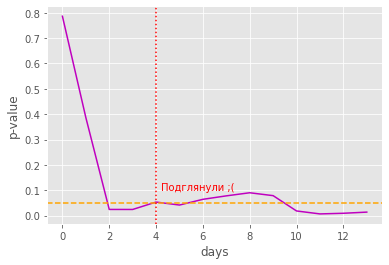

In [3]:
alpha, beta = 0.05, 0.05
p_c, p_t, MDE = 0.2, 0.2*1.2, 0.1
days = 14
pvalues = []

n_obs = zt_ind_solve_power(effect_size=MDE,
                                 nobs1=None,
                                 alpha=alpha,
                                 power=(1 - beta),
                                 ratio=1,
                                 alternative='larger')

n_obs = (n_obs + (days * 2 - n_obs % days))
pvalues = []
x_c = sts.bernoulli(p_c).rvs(int(n_obs // 2), random_state=55)
x_t = sts.bernoulli(p_t).rvs(int(n_obs // 2), random_state=77)
x_c = x_c.reshape(days, int(n_obs // 2 // days))
x_t = x_t.reshape(days, int(n_obs // 2 // days))


for day in range(days):
    x_c_day = x_c[:day+1]
    x_t_day = x_t[:day+1]

    pc_hat = x_c_day.sum()
    pt_hat = x_t_day.sum()

    pval = proportions_ztest([pt_hat, pc_hat],
                             [x_t_day.reshape(-1).shape[0], x_c_day.reshape(-1).shape[0]],
                             value = 0,
                             alternative = 'larger')[1]
    pvalues.append(pval)

ax = sns.lineplot(x=range(days), y=pvalues, color='m')
ax.axhline(0.05, ls='--', color='orange');
ax.axvline(4, ls='dotted', color='red' );
ax.set(xlabel='days', ylabel='p-value');
ax.text(4.2, 0.1, "Подглянули ;(", color='r');

print(f"Если будем подглядывать, то остановимся на 4й день, т.к. p-value = {pvalues[4]:.4f}")
print(f"Аналогично и с 6-го по 9 день")

print(f"""Ошибка 2-го рода: {np.mean(np.array(pvalues[:9]) < 0.05):.4f}""")


*Видим, что останавиливать раньше времени АБ-тест нехорошо, т.к. заведомо ложные выводы легко могут быть сделаны.*

*АБ-тест нужно планировать в разрезе ошибок 1,2 рода, кол-ва наблюдений, MDE + ОБЯЗАТЕЛЬНО ПО ВРЕМЕНИ и не делать выводы по промежуточным результатам теста*